In [59]:
import SSC
from SSC import train, Analyzer

import numpy as np
import pandas as pd
from rdkit import Chem

# Train

In [ ]:
"A single command for full pipeline of deep learning."
"It returns the path of the folder where the training results are saved."

model_path= train(data="SciData_emi", target=['Emi_eV'])

In [ ]:
"SGC bascially adopts GAT for graph convolution, but you can try other algorithms by calling other networks."

# model_path= train(data="SciData_emi", target=['Emi_eV'], network= "SSC_DMPNN")

In [ ]:
"Hyperparameter configurations are also declared as keyword arguments of train function."

# model_path= train(data="SciData_emi", target=['Emi_eV'], conv_layers= 6, hidden_dim=256)

# Predict & Analyze

In [5]:
# Analyzer handles the trained model. Getting the folder name as input, it loads the trained models.
# analyzer = Analyzer(model_path.split('/')[-1])
analyzer = Analyzer('trained_SSC_GAT')

founded model: ./_Models/trained_SSC_GAT
Device: cuda:1
#params: 2837891
Loading params from ./_Models/trained_SSC_GAT/final.pth
Sculptor Index: (6, 2, 0)


In [29]:

smi = "S1C(C2=CC=C([N+](=O)[O-])S2)=CC=C1N(C)C"
smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))

In [30]:
# Analyzer supports the prediction for the pair of choromophore and solvent.
analyzer.predict(smi, "CCO")

{('CN(C)c1ccc(-c2ccc([N+](=O)[O-])s2)s1',
  'CCO'): array([2.1600971], dtype=float32)}

In [36]:
# The parameters in SSC approach, including Reference Property (RP), Subgroup contribution (SC), and Proximity effect factor (PEF), are accessibe
RP = analyzer.get_score(smi, "CCO", 
                        key='RP', inverse_transform=True, is_key_relative=True)
SC = analyzer.get_score(smi, "CCO", 
                        key='SC', inverse_transform=False, is_key_relative=True)
PEF = analyzer.get_score(smi, "CCO", 
                        key='PEF', inverse_transform=False, is_key_relative=False)
print(SC)
print(PEF)

[[-0.71676725]
 [-0.62544817]
 [-0.3952209 ]
 [-0.3952209 ]]
[[0.99320155]
 [0.97607774]
 [0.87630403]
 [0.87630403]]


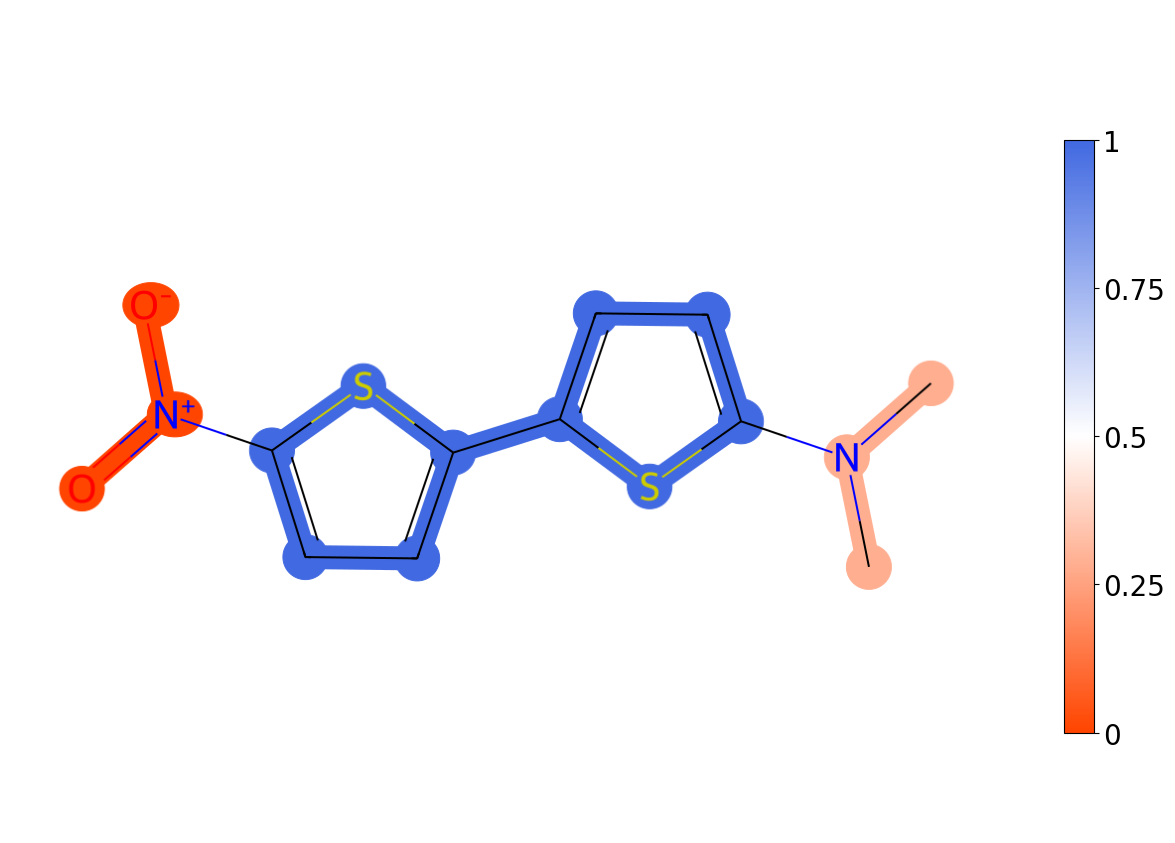

In [32]:
# These parameters can be visualized
result = analyzer.plot_score(smi, "CCO", 
                             key="SC", inverse_transform=False, is_key_relative=True, 
                            score_scaler = lambda x: (x-min(x))/(max(x)-min(x)) )

In [33]:
subgroups = analyzer.get_fragment(smi)
subgroup_smiles = [s.smiles for s in subgroups]

In [42]:
pd.DataFrame(
    {
     "Smiles":subgroup_smiles,
     "SC": SC.reshape(-1),
     "PEF": PEF.reshape(-1)
    }
)

,Smiles,SC,PEF
0,*[N+](=O)[O-],-0.716767,0.993202
1,*N(C)C,-0.625448,0.976078
2,c1ccsc1,-0.395221,0.876304
3,c1ccsc1,-0.395221,0.876304


# Calculate NSC

In [ ]:
"To calculate NSC, you need to calculate the SC values in 20 solvents, and then subtract their average from SC values"

In [51]:
solvent_data = pd.read_csv("solvent_feature.csv")
solvent_data = solvent_data.sort_values("ET(30)")

SC_dict = {"Smiles": subgroup_smiles}
for solv in solvent_data['smiles']:
    SC_dict[solv]=analyzer.get_score(smi, solv, 
                        key='SC', inverse_transform=False, is_key_relative=True).reshape(-1)

In [55]:
SC_table = pd.DataFrame(SC_dict)
SC_table

,Smiles,C1CCCCC1,CCCCCC,Cc1ccccc1,c1ccccc1,CCOCC,C1COCCO1,C1CCOC1,CCOC(C)=O,ClC(Cl)Cl,...,CC(C)=O,CN(C)C=O,CS(C)=O,CC#N,CC(C)O,CCCCO,CCCO,CCO,CO,O
0,*[N+](=O)[O-],-0.641684,-0.612028,-0.705332,-0.732514,-0.676838,-0.709661,-0.717394,-0.699740,-0.705736,...,-0.736860,-0.735656,-0.740242,-0.726222,-0.702331,-0.687394,-0.702469,-0.716767,-0.730214,-0.742696
1,*N(C)C,-0.517933,-0.479778,-0.591604,-0.626999,-0.574823,-0.607109,-0.621330,-0.595414,-0.603249,...,-0.637275,-0.638063,-0.640721,-0.637280,-0.606145,-0.585922,-0.607068,-0.625448,-0.643339,-0.657051
2,c1ccsc1,-0.375371,-0.336113,-0.381349,-0.404760,-0.354828,-0.364374,-0.408231,-0.366981,-0.403901,...,-0.440001,-0.428176,-0.461074,-0.428758,-0.391818,-0.381286,-0.388396,-0.395221,-0.399769,-0.436775
3,c1ccsc1,-0.375371,-0.336113,-0.381349,-0.404760,-0.354828,-0.364374,-0.408231,-0.366981,-0.403901,...,-0.440001,-0.428176,-0.461074,-0.428758,-0.391818,-0.381286,-0.388396,-0.395221,-0.399769,-0.436775


In [66]:
NSC_table = SC_table.copy()
NSC_table.iloc[:,1:] = np.array(SC_table.iloc[:,1:])- np.mean(np.array(SC_table.iloc[:,1:]), axis=1).reshape(-1,1)
NSC_table

,Smiles,C1CCCCC1,CCCCCC,Cc1ccccc1,c1ccccc1,CCOCC,C1COCCO1,C1CCOC1,CCOC(C)=O,ClC(Cl)Cl,...,CC(C)=O,CN(C)C=O,CS(C)=O,CC#N,CC(C)O,CCCCO,CCCO,CCO,CO,O
0,*[N+](=O)[O-],0.065839,0.095495,0.002190,-0.024992,0.030685,-0.002139,-0.009872,0.007782,0.001786,...,-0.029337,-0.028134,-0.032719,-0.018700,0.005192,0.020128,0.005053,-0.009245,-0.022691,-0.035174
1,*N(C)C,0.088532,0.126687,0.014861,-0.020534,0.031642,-0.000644,-0.014865,0.011051,0.003215,...,-0.030811,-0.031598,-0.034256,-0.030815,0.000320,0.020543,-0.000603,-0.018983,-0.036874,-0.050586
2,c1ccsc1,0.023612,0.062869,0.017634,-0.005777,0.044154,0.034608,-0.009249,0.032001,-0.004919,...,-0.041018,-0.029194,-0.062092,-0.029775,0.007164,0.017697,0.010587,0.003762,-0.000787,-0.037792
3,c1ccsc1,0.023612,0.062869,0.017634,-0.005777,0.044154,0.034608,-0.009249,0.032001,-0.004919,...,-0.041018,-0.029194,-0.062092,-0.029775,0.007164,0.017697,0.010587,0.003762,-0.000787,-0.037792
